## Fine Tuning Huggingface Transformers for Classification

In [ ]:
!nvidia-smi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install --upgrade datasets
!pip install transformers -U 
!pip install accelerate -U

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Set up the cuda devices. Be good citizens of the machine.

In [4]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="2"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
import torch 

def get_available_devices():
    """Get IDs of all available GPUs.

    Returns:
        device (torch.device): Main device (GPU 0 or CPU).
        gpu_ids (list): List of IDs of all GPUs that are available.
        device_props (list): List of gpu _CudaDeviceProperties dictionaries generally ordered fastest to slowest
    """
    gpu_ids = []
    device_props = []
    if torch.cuda.is_available():
        gpu_ids += [gpu_id for gpu_id in range(torch.cuda.device_count())]
        for i in range(torch.cuda.device_count()):
            device_props.append(torch.cuda.get_device_properties(i))
        device = torch.device(f'cuda:{gpu_ids[0]}')
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')

    return device, gpu_ids, device_props 

device, gpu_ids, device_props = get_available_devices()
print(device, gpu_ids, device_props)

cuda:0 [0] [_CudaDeviceProperties(name='NVIDIA RTX A6000', major=8, minor=6, total_memory=48676MB, multi_processor_count=84)]


### Huggingface Datasets

Look at the datasets available, but then load the emotions dataset

In many cases, you'll find yourself working with data that is either stored on your laptop or on a remote server in your organization. Huggingface Datasets provides several loading scripts to handle local and remote datasets. 

```asciidoc
[[dataset-loading]]
.How to load datasets in various formats
[options="header"]
|======
| Data format | Loading script | Example
| CSV | `csv` | `load_dataset("csv", data_files="my_file.csv")` 
| Text | `text` | `load_dataset("text", data_files="my_file.txt")` 
| JSON | `json` | `load_dataset("json", data_files="my_file.jsonl")`
|======
```

As you can see for each data format, we just need to pass the relevant loading script to the `load_dataset()` function, along with a `data_files` argument that specifies the path or URL to one or more files. For example, the source files for the `emotion` dataset are actually hosted on Dropbox, so an alternative way to load the dataset is to first download one of the splits:

Let's load a local dataset from train.txt. It has no column headers and each tweet and emotion are separated by a semicolon. Nevertheless, this is quite similar to a CSV file, so we can load the dataset locally by using the csv script and pointing the data_files argument to the train.txt file:

In [51]:
df = pd.read_csv('./log_lines.csv',sep='|')
df = df.rename(columns={'log_line':'text', 'labels':'label'})
pd.set_option('display.max_colwidth', None)
df.head()

,text,label
0,Jan 23 06:25:05 intranet-server CRON[22883]: pam_unix(cron:session): session closed for user root\n,benign
1,Jan 23 06:39:01 intranet-server CRON[23064]: pam_unix(cron:session): session opened for user root by (uid=0)\n,benign
2,Jan 23 06:39:01 intranet-server CRON[23064]: pam_unix(cron:session): session closed for user root\n,benign
3,Jan 23 06:47:01 intranet-server CRON[23137]: pam_unix(cron:session): session opened for user root by (uid=0)\n,benign
4,Jan 23 06:47:02 intranet-server CRON[23137]: pam_unix(cron:session): session closed for user root\n,benign


In [56]:
sample = df.sample(10)
sample.head(len(sample))

,text,label
3301864,Jan 27 14:51:47 dnsmasq[14167]: query[AAAA] mail.flores.wheeler.biz from 10.38.243.125\n,benign
2780828,"10.38.243.125 - - [30/Jan/2022:07:41:57 +0000] ""GET /wp-content/plugins/nuke HTTP/1.1"" 404 363 ""-"" ""Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1)""\n",attacker_http:dirb:foothold
894614,"172.17.130.196 - - [18/Jan/2022:12:32:34 +0000] ""GET /wp-includes/css/dist/components/webboard HTTP/1.1"" 404 363 ""-"" ""Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1)""\n",attacker_http:dirb:foothold
2164867,Feb 5 19:22:33 dnsmasq[14664]: reply intranet.mannsmith.harrison.com is 192.168.131.215\n,benign
4484246,Feb 8 11:43:04 dnsmasq[14481]: query[AAAA] db.local.clamav.net from 10.182.193.181\n,benign
1339342,Jan 19 14:07:17 dnsmasq[14755]: reply secure.gravatar.com is 192.0.73.2\n,benign
2694183,Jan 30 14:32:37 dnsmasq[14596]: reply pki-goog.l.google.com is 2a00:1450:400d:807::2003\n,benign
3782890,"10.182.193.78 - - [07/Feb/2022:11:09:52 +0000] ""GET /wp-includes/blocks/missing/spam HTTP/1.1"" 404 363 ""-"" ""Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1)""\n",attacker_http:dirb:foothold
710577,"172.17.130.196 - - [18/Jan/2022:12:23:46 +0000] ""GET /wp-includes/js/quarterly HTTP/1.1"" 404 363 ""-"" ""Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1)""\n",attacker_http:dirb:foothold
3271439,Jan 27 10:01:55 dnsmasq[14167]: forwarded mail.dmz.flores.wheeler.biz to 127.0.0.1\n,benign


In [8]:
df['label'].value_counts()

label
benign                                                                      2423075
attacker_http:dirb:foothold                                                 1689473
attacker:dnsteal:dnsteal-received                                            372856
attacker_http:foothold:wpscan                                                 27671
dns_scan:foothold                                                              3305
foothold:service_scan                                                          1656
foothold:network_scan                                                           628
crack_passwords:escalate                                                        333
attacker_vpn:foothold                                                           224
attacker_http:foothold:webshell_cmd                                             126
escalate:webshell_cmd                                                           106
attacker_change_user:escalate                                         

In [9]:
def stratified_sample(df, label_column, min_count=0, max_count=np.inf):
    '''
    Samples each label from data, equally according to the minimum number of samples.
    Utilizing oversampling to ensure each column has at least min_values.
    
    Parameters
    ----------
    
    df : pandas.DataFrame
        Dataframe to sample from 
    label_column: str
        column name of the label column
    min_count: int
        The minimum number of values you want each label to have
    
    '''
    counts = df.groupby(label_column).count().to_dict()
    counts['text']
    dfs = []
    for key, val in counts['text'].items():
        df_label = df[df[label_column] == key]
        if val > max_count:
            df_label = df_label.sample(max_count, replace=False)
        elif val < min_count:
            df_label = df_label.sample(min_count, replace=True)
        dfs.append(df_label)
    final_df = pd.concat(dfs, axis=0)
    return final_df


In [10]:
sample_df = stratified_sample(df, 'label', max_count=1000)
sample_df.head()

,text,label
273688,Jan 24 13:50:24 dnsmasq[3468]: query[A] 3x6-.1...,attacker:dnsteal:dnsteal-dropped
273689,Jan 24 13:50:24 dnsmasq[3468]: forwarded 3x6-....,attacker:dnsteal:dnsteal-dropped
273690,Jan 24 13:50:25 dnsmasq[3468]: query[A] 3x6-.1...,attacker:dnsteal:dnsteal-dropped
273691,Jan 24 13:50:25 dnsmasq[3468]: forwarded 3x6-....,attacker:dnsteal:dnsteal-dropped
273692,Jan 24 13:50:26 dnsmasq[3468]: query[A] 3x6-.1...,attacker:dnsteal:dnsteal-dropped


In [11]:
sample_df['label'].value_counts()

label
attacker_http:dirb:foothold                                                 100000
attacker:dnsteal:dnsteal-received                                           100000
benign                                                                      100000
attacker_http:foothold:wpscan                                                27671
dns_scan:foothold                                                             3305
foothold:service_scan                                                         1656
foothold:network_scan                                                          628
crack_passwords:escalate                                                       333
attacker_vpn:foothold                                                          224
attacker_http:foothold:webshell_cmd                                            126
escalate:webshell_cmd                                                          106
attacker_change_user:escalate                                                   9

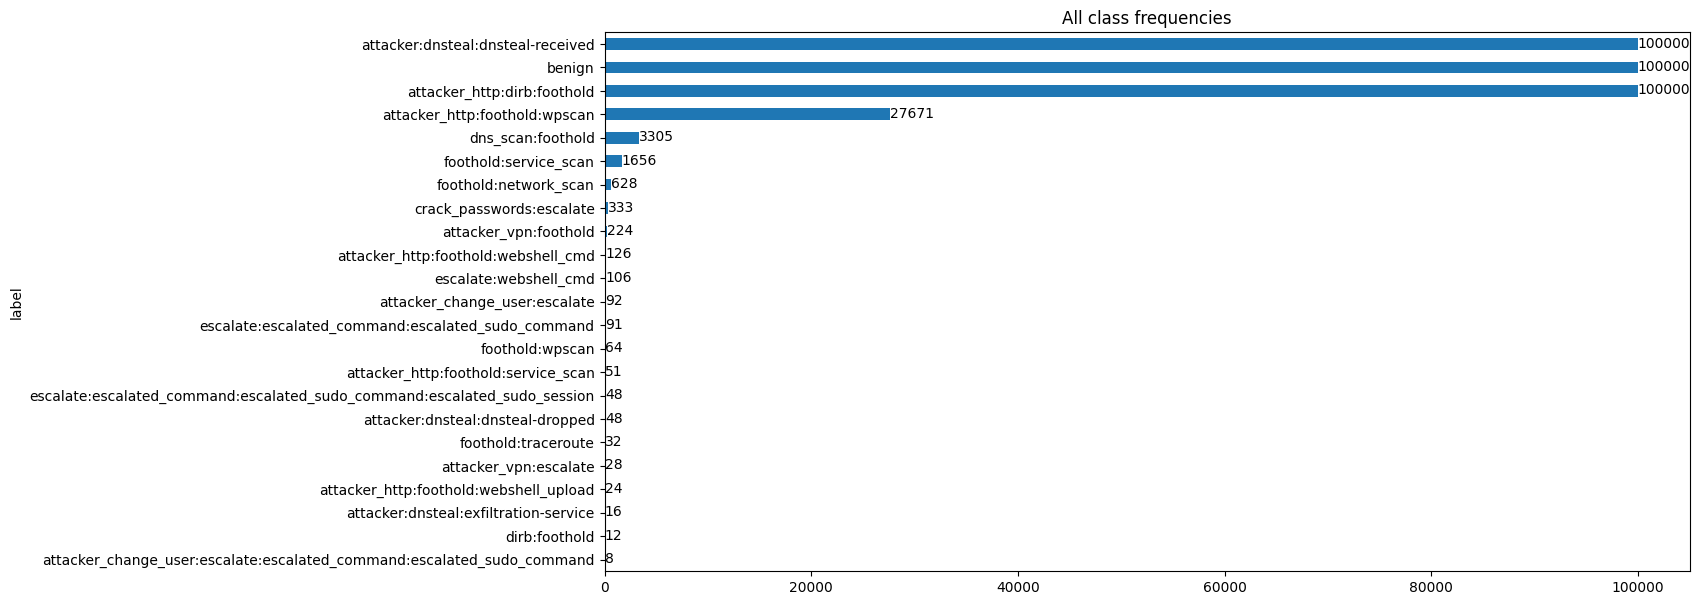

In [12]:
# Plotting the bar chart

def plot_value_counts(df_slice, title="Class frequencies"):

    plt.figure(figsize=(14,7))
    ax = df_slice.value_counts(ascending=True).plot.barh()

    # Adding labels to the bars
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_width() + 0.1, i.get_y() + 0.1, str(round(i.get_width(), 2)), fontsize=10, color='black')

    # Adding title
    plt.title(title)

    # Showing the plot
    plt.show()
    
plot_value_counts(sample_df['label'], "All class frequencies")

In [13]:
from datasets import load_dataset
from datasets import Dataset
log_lines = Dataset.from_pandas(sample_df)

Here we've also specified the type of delimiter and the names of the columns. An even simpler approach is to just point the data_files argument to the URL itself which will automatically download and cache the dataset for you. As you can see, the load_dataset() function is very versatile. Look at the Huggingface Datasets documentation to get a complete overview.

In [14]:
log_lines

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 334563
})

In [15]:
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()

# label_nums = label_encoder.fit_transform(log_lines['labelname'])
# label_nums

In [16]:
log_lines = log_lines.class_encode_column('label')

Casting to class labels:   0%|          | 0/334563 [00:00<?, ? examples/s]

In [17]:
log_lines

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 334563
})

In [18]:
log_lines_df = pd.DataFrame(log_lines)

In [50]:
log_lines_df['labelname'] = sample_df['label'].values
mapping = log_lines_df[['labelname','label']].drop_duplicates()
mapping.head(len(mapping))
mapping.to_csv('label_mappings.csv', index=False)

We can then split it into train, test, and validation sets as follows:

In [20]:
from datasets import DatasetDict

def train_test_valid_split(dataset, label_column, trainpercent, validpercent, testpercent):
    # Split once into train and (valid and test)
    train_testvalid = dataset.train_test_split(test_size=validpercent + testpercent, stratify_by_column=label_column)
    # Split (valid and test) into train and test - call the train of this part validation
    newtestsize = testpercent / (validpercent + testpercent)
    test_valid = train_testvalid['test'].train_test_split(test_size=newtestsize, stratify_by_column=label_column)
    # gather all the pieces to have a single DatasetDict
    train_test_valid_dataset = DatasetDict({
        'train': train_testvalid['train'],
        'validation': test_valid['train'],
        'test': test_valid['test'],
        })
    return train_test_valid_dataset

In [21]:
log_lines = train_test_valid_split(log_lines,'label',  0.60, 0.20, 0.20)
log_lines

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 200737
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 66913
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 66913
    })
})

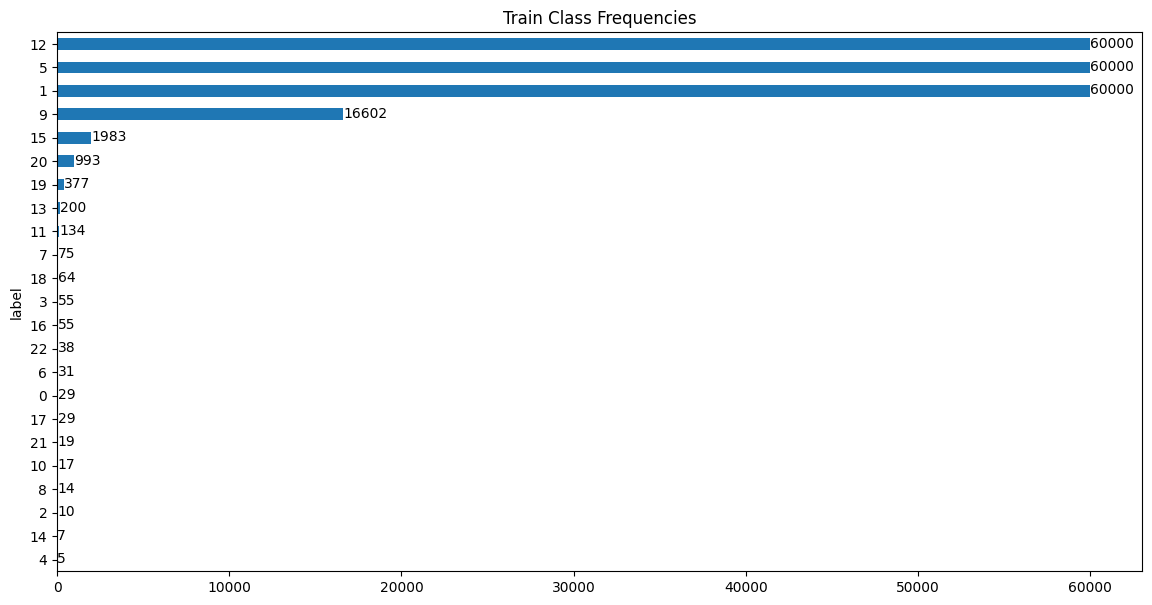

In [22]:
log_lines.set_format(type="pandas")
df_train = log_lines["train"][:]
plot_value_counts(df_train['label'], "Train Class Frequencies")

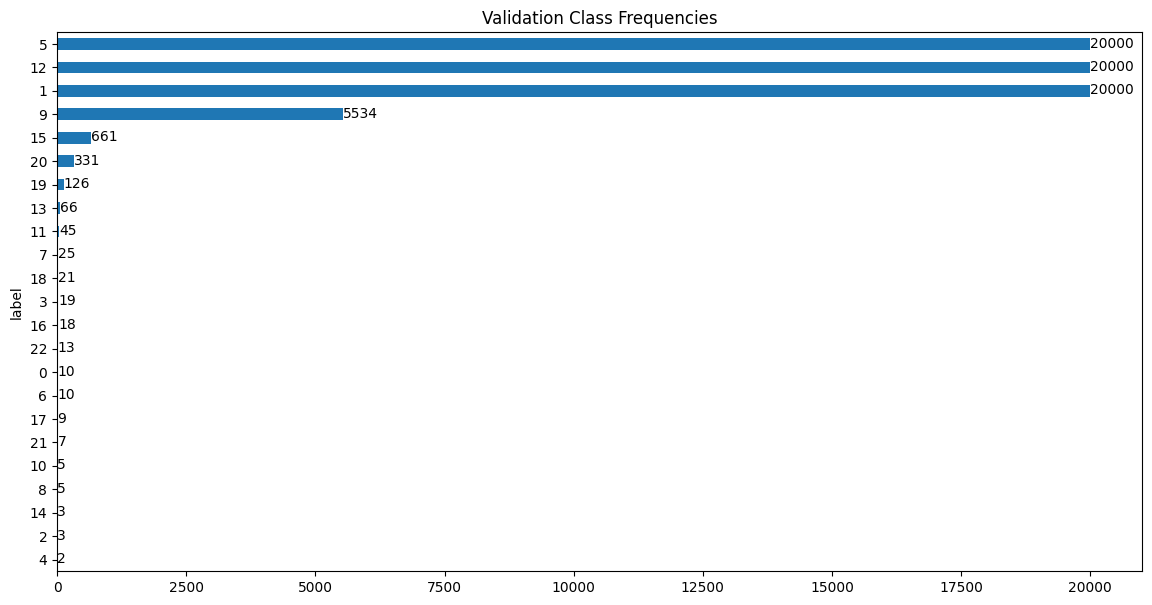

In [23]:
df_validation = log_lines["validation"][:]
plot_value_counts(df_validation['label'], "Validation Class Frequencies")

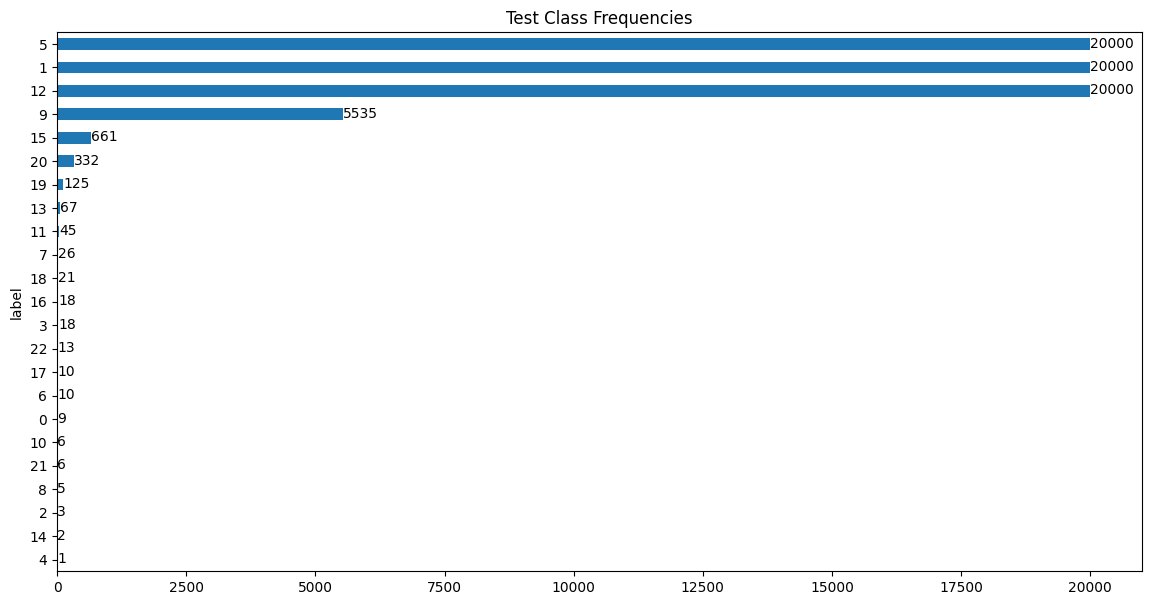

In [24]:
df_test = log_lines["test"][:]
plot_value_counts(df_test['label'], "Test Class Frequencies")

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

Now we are done with Pandas, let's reset the output format of our dataset

In [25]:
log_lines.reset_format()

### Now let's get the transformer going

In [26]:
# model_ckpt = "bert-base-cased"
# model_ckpt = "xlnet-base-cased"   # This only works for the first training run
model_ckpt = "distilbert-base-uncased"

Set up the tokenizer for our model and encode all the input

In [27]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [28]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [29]:
log_lines_encoded = log_lines.map(tokenize, batched=True, batch_size=1000)

Map:   0%|          | 0/200737 [00:00<?, ? examples/s]

Map:   0%|          | 0/66913 [00:00<?, ? examples/s]

Map:   0%|          | 0/66913 [00:00<?, ? examples/s]

In [30]:
print(log_lines_encoded["train"].column_names)

['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']


In [31]:
# tokenized_df_train = pd.DataFrame(log_lines_encoded['train'])
# tokenized_df_test = pd.DataFrame(log_lines_encoded['test'])
# tokenized_df_val = pd.DataFrame(log_lines_encoded['validation'])
# tokenized_df = pd.concatenate([tokenized_df_train, tokenized_df_test, tokenized_df_val], axis=0)
# tokenized_df.to_csv(f'./tokenizations.csv',sep='|',index=False)

We can see that the words have been mapped to unique integers in the input_ids field. 
Here we can see the result of padding: the first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens. The attention_mask identifies which integers are valid and which are to be ignored. 

Now that we have the input_ids, we can convert them back into tokens by using the tokenizer's convert_ids_to_tokens() method:

In [32]:
tokens = tokenizer.convert_ids_to_tokens(log_lines_encoded['train'][0]['input_ids'])
print(tokens)

['[CLS]', 'jan', '20', '10', ':', '12', ':', '15', 'd', '##ns', '##mas', '##q', '[', '147', '##55', ']', ':', 'reply', 'p', '##x', '-', 'eu', '.', 'ad', '##hi', '##gh', '.', 'net', 'is', '91', '.', '207', '.', '59', '.', '214', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

#### Now load the transformer model with a preset classification head

In [33]:
from transformers import AutoModelForSequenceClassification
label_nums = sorted(list(set(log_lines['train']['label'])))
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=len(label_nums))
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

#### Training functions

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(len(labels), len(labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".5f", ax=ax, colorbar=False)
    ax.set_xticklabels(labels, rotation=90)  
    plt.title("Normalized confusion matrix")
    plt.show()

In [36]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [37]:
from transformers import Trainer, TrainingArguments

def train_model(model, model_name, epochs, train_data, validation_data):
    batch_size = 32
    logging_steps = len(train_data) // batch_size
    training_args = TrainingArguments(output_dir=model_name,
                                  overwrite_output_dir = True,
                                  num_train_epochs=epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,                 # Don't push my model to Huggingface hub
                                  report_to="none",                    # Don't push stats to wandb.ai
                                  log_level="error")
    
    trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=train_data,
                  eval_dataset=validation_data,
                  tokenizer=tokenizer)
    
    trainer.train();
    return trainer

In [38]:
train_data = log_lines_encoded['train']
validation_data = log_lines_encoded['validation']

In [39]:
trainer = train_model(model, f"insyt", 3, train_data, validation_data)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.043500,0.012039,0.996548,0.996507
2,0.005900,0.003206,0.999327,0.999207
3,0.002300,0.002241,0.999462,0.999394


In [ ]:
!nvidia-smi

In [41]:
preds_output = trainer.predict(log_lines_encoded["test"])
preds_output.metrics

{'test_loss': 0.00201437552459538,
 'test_accuracy': 0.9994320983964252,
 'test_f1': 0.9993642105798166,
 'test_runtime': 279.7761,
 'test_samples_per_second': 239.166,
 'test_steps_per_second': 7.477}

In [42]:
log_lines_encoded["test"].features["label"]

ClassLabel(names=['attacker:dnsteal:dnsteal-dropped', 'attacker:dnsteal:dnsteal-received', 'attacker:dnsteal:exfiltration-service', 'attacker_change_user:escalate', 'attacker_change_user:escalate:escalated_command:escalated_sudo_command', 'attacker_http:dirb:foothold', 'attacker_http:foothold:service_scan', 'attacker_http:foothold:webshell_cmd', 'attacker_http:foothold:webshell_upload', 'attacker_http:foothold:wpscan', 'attacker_vpn:escalate', 'attacker_vpn:foothold', 'benign', 'crack_passwords:escalate', 'dirb:foothold', 'dns_scan:foothold', 'escalate:escalated_command:escalated_sudo_command', 'escalate:escalated_command:escalated_sudo_command:escalated_sudo_session', 'escalate:webshell_cmd', 'foothold:network_scan', 'foothold:service_scan', 'foothold:traceroute', 'foothold:wpscan'], id=None)

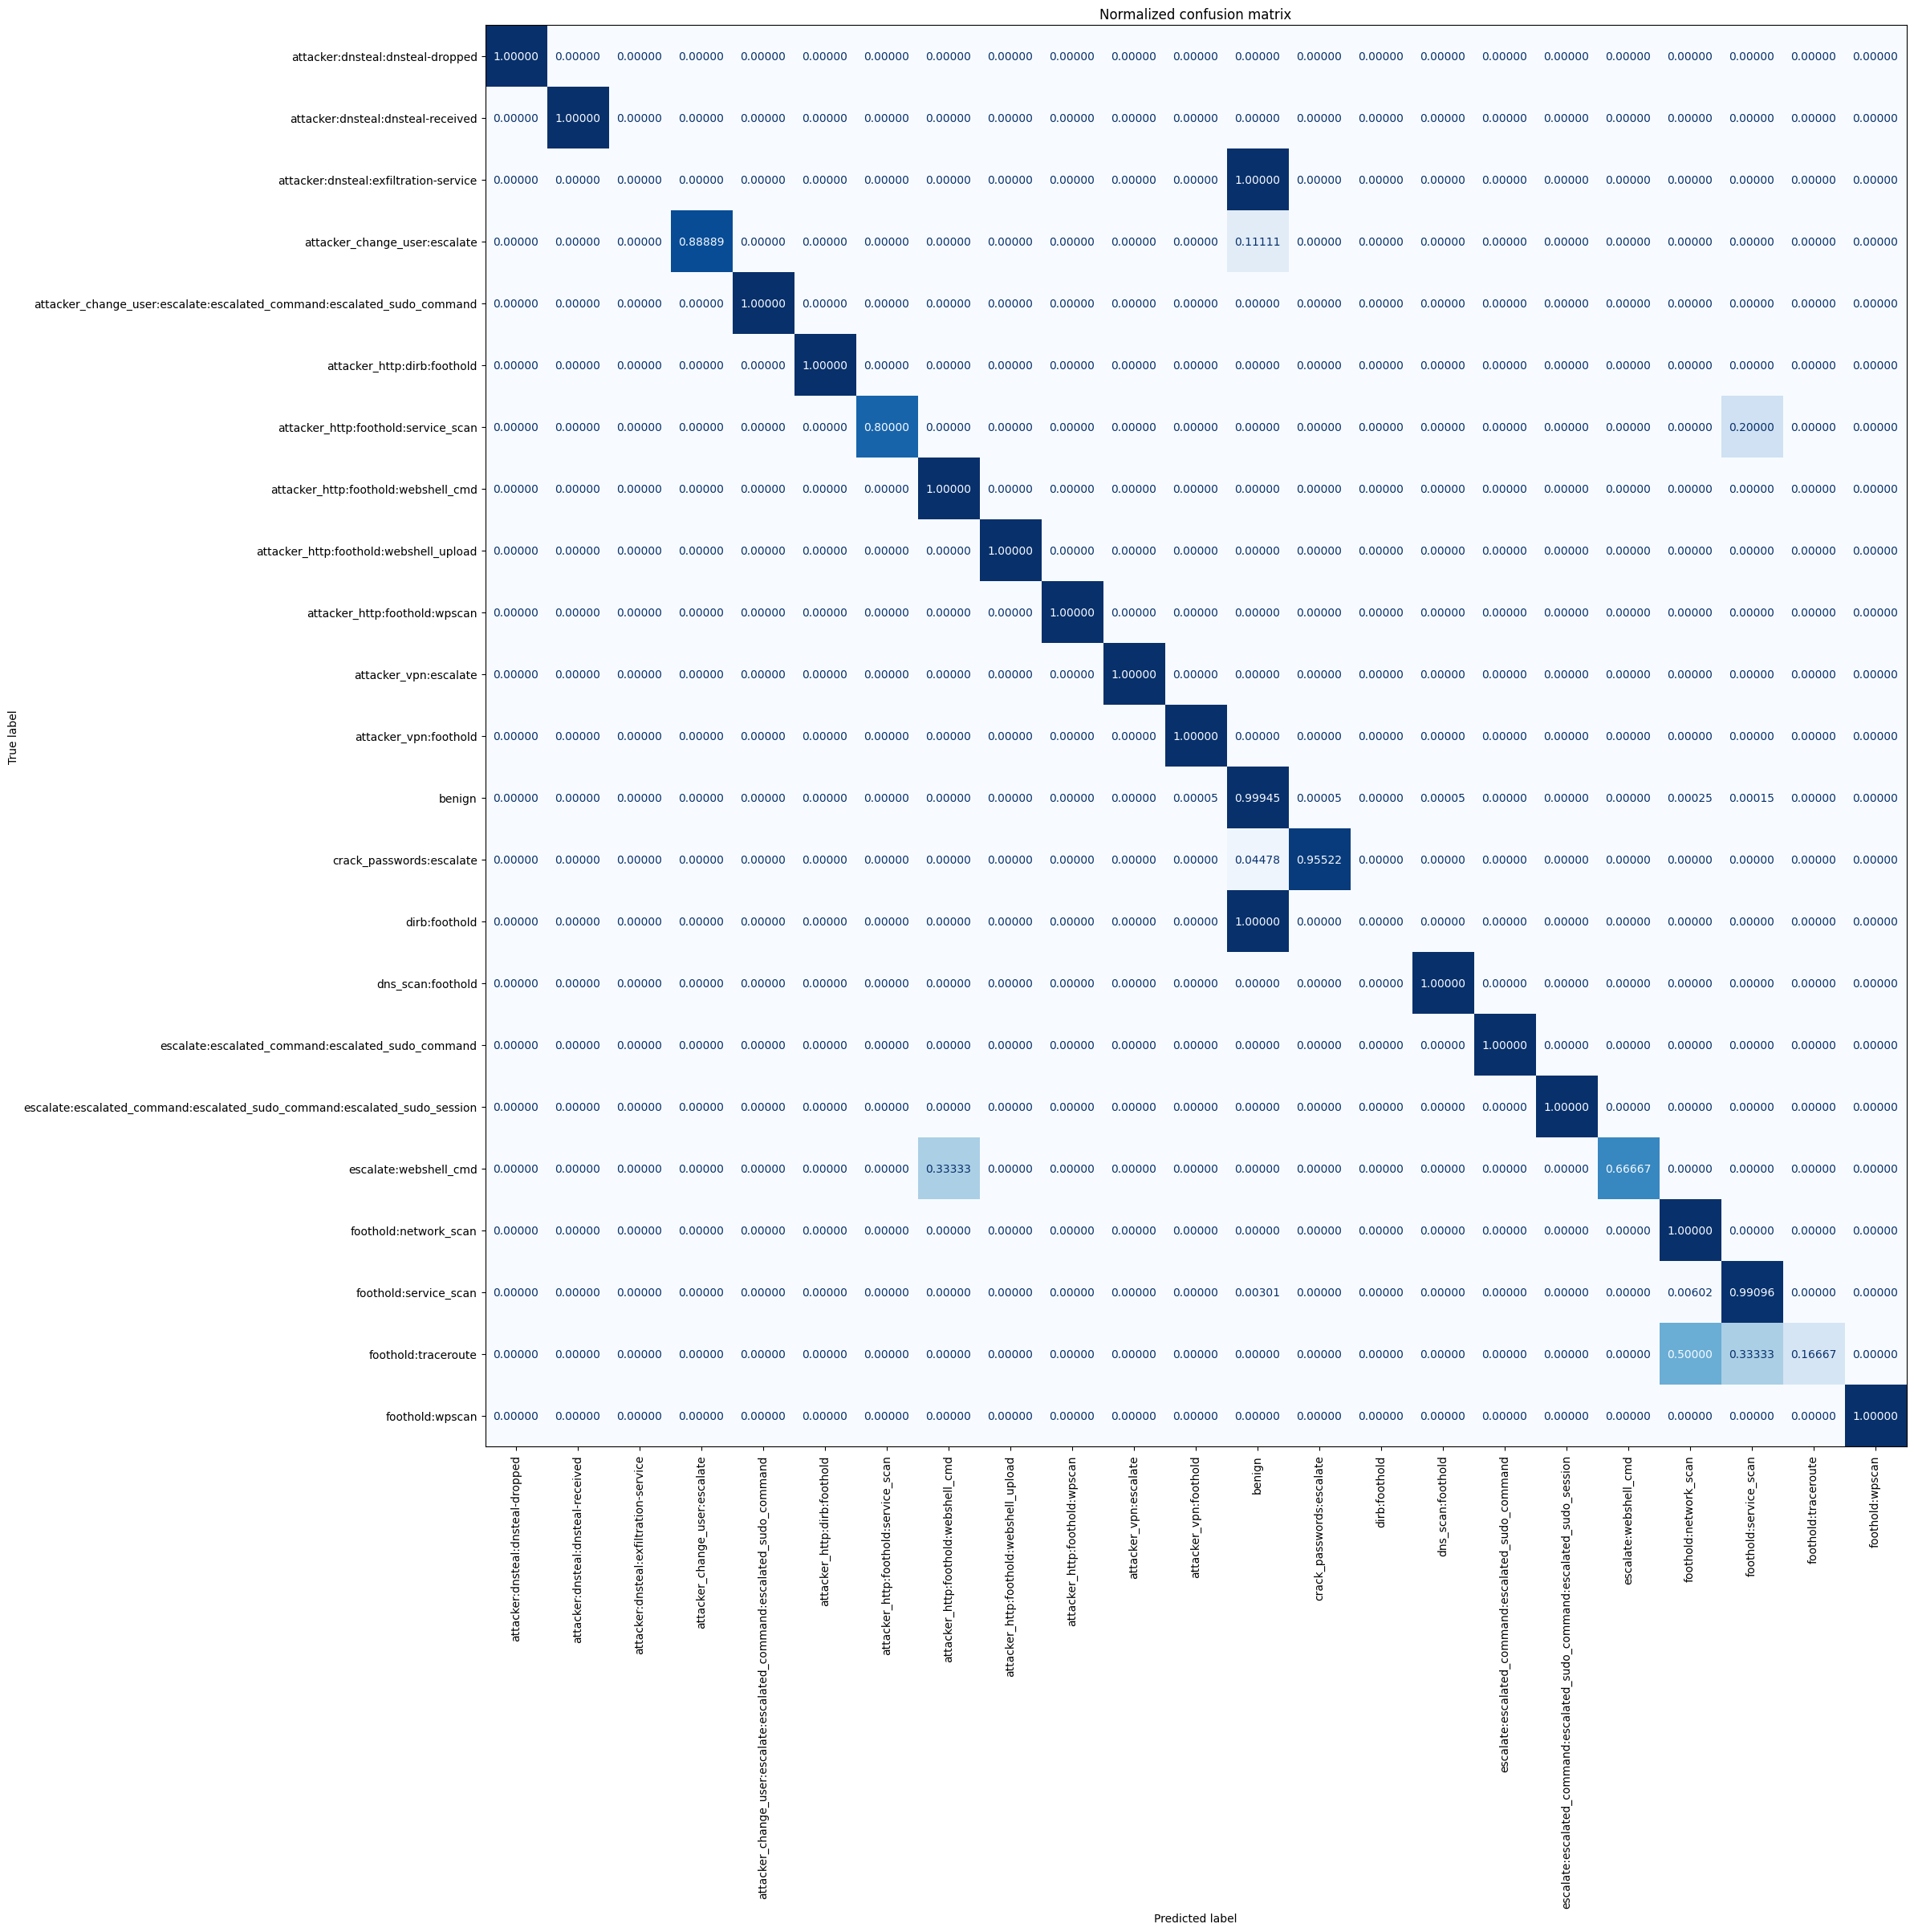

In [43]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(log_lines_encoded["test"]["label"])
labels = log_lines_encoded["test"].features["label"].names

plot_confusion_matrix(y_preds, y_valid, labels)


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# trainer.push_to_hub("isaacwilliam4/insyt")

#### Let's try putting on a different classifier head and see how it does
NOTE: Can't do this with XLNet right now. The model setup for XLNet is totally different

In [44]:
qmodel = model

In [45]:
qmodel.pre_classifier.out_features

768

In [46]:
import torch
import torch.nn as nn

model_dropout = 0.25
classifier_dropout = 0.3
base_model_output_size = qmodel.pre_classifier.out_features

qmodel.num_labels = num_labels
qmodel.classifier = nn.Sequential(
            nn.Dropout(model_dropout),
            #nn.Conv1d(base_model_output_size, base_model_output_size//16, 3, stride=2),
            nn.Linear(base_model_output_size, base_model_output_size//8),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(base_model_output_size//8, base_model_output_size//16),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(base_model_output_size//16, num_labels),
        )

NameError: name 'num_labels' is not defined

In [ ]:
print(qmodel)

Train the new model and see how it does. Add more epochs because we have our dropout rates high. Hopefully it helps it generalize a bit better.

In [ ]:
trainer = train_model(model, f"{model_ckpt}-log-line-3layer-Classification", 3, train_data, validation_data)

In [ ]:
preds_output = trainer.predict(log_lines_encoded["validation"])
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(log_lines_encoded["validation"]["label"])
labels = log_lines_encoded["validation"].features["label"].names

plot_confusion_matrix(y_preds, y_valid, labels)